In [1]:
# At the beginning of your notebook, add:
import torch
import time
from datetime import datetime

# Check for GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Optional: Set memory usage behavior for CUDA if available
if torch.cuda.is_available():
    # Optional: for better performance on some systems
    torch.backends.cudnn.benchmark = True
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Memory Allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    print(f"CUDA Memory Cached: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")

Using device: cpu


In [2]:
# Add to imports
import time
import psutil
import numpy as np
from tqdm import tqdm

# Create a benchmarking wrapper
def benchmark_function(func):
    def wrapper(*args, **kwargs):
        # Start timing and power measurement
        start_time = time.time()
        start_cpu_percent = psutil.cpu_percent(interval=None)
        
        # Execute the function
        result = func(*args, **kwargs)

# Enhanced benchmarking wrapper
def benchmark_function(func):
    def wrapper(*args, **kwargs):
        # Initialize power measurement if GPU is available
        gpu_power_samples = []
        gpu_power_interval = 0.1  # seconds between power samples
        
        if torch.cuda.is_available() and PYNVML_AVAILABLE:
            try:
                pynvml.nvmlInit()
                device_count = pynvml.nvmlDeviceGetCount()
                handles = [pynvml.nvmlDeviceGetHandleByIndex(i) for i in range(device_count)]
                
                # Start power sampling in a separate thread
                import threading
                import time
                
                def sample_gpu_power():
                    while not stop_sampling.is_set():
                        try:
                            powers = [pynvml.nvmlDeviceGetPowerUsage(h) / 1000.0 for h in handles]  # Convert mW to W
                            gpu_power_samples.append(sum(powers))  # Total power across all GPUs
                            time.sleep(gpu_power_interval)
                        except:
                            break
                
                stop_sampling = threading.Event()
                power_thread = threading.Thread(target=sample_gpu_power)
                power_thread.daemon = True
                power_thread.start()
            except:
                print("Failed to initialize NVML for GPU power measurement")
        
        # Start timing and CPU measurement
        start_time = time.time()
        start_cpu_percent = psutil.cpu_percent(interval=None)
        
        # Memory before execution
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()
            start_gpu_mem = torch.cuda.memory_allocated() / 1e9  # GB
        
        start_ram = psutil.virtual_memory().used / 1e9  # GB
        
        # Execute the function
        result = func(*args, **kwargs)
        
        # Stop timing and calculate metrics
        end_time = time.time()
        elapsed_time = end_time - start_time
        end_cpu_percent = psutil.cpu_percent(interval=None)
        
        # Memory after execution
        end_ram = psutil.virtual_memory().used / 1e9  # GB
        ram_used = end_ram - start_ram
        
        # GPU metrics
        if torch.cuda.is_available():
            gpu_memory_peak = torch.cuda.max_memory_allocated() / 1e9  # GB
            gpu_memory_used = gpu_memory_peak - start_gpu_mem
            print(f"GPU Memory Peak: {gpu_memory_peak:.2f} GB")
            print(f"GPU Memory Used: {gpu_memory_used:.2f} GB")
            torch.cuda.reset_peak_memory_stats()
        
        # Stop power sampling if active
        if 'stop_sampling' in locals():
            stop_sampling.set()
            if 'power_thread' in locals():
                power_thread.join(timeout=1.0)
            
            if gpu_power_samples:
                avg_power = sum(gpu_power_samples) / len(gpu_power_samples) if gpu_power_samples else 0
                max_power = max(gpu_power_samples) if gpu_power_samples else 0
                print(f"GPU Avg Power: {avg_power:.2f} W")
                print(f"GPU Max Power: {max_power:.2f} W")
                print(f"GPU Energy Used: {avg_power * elapsed_time:.2f} J")
        
        # CPU usage
        cpu_percent = (start_cpu_percent + end_cpu_percent) / 2
        ram_percent = psutil.virtual_memory().percent
        
        print(f"\nPerformance Metrics:")
        print(f"Execution Time: {elapsed_time:.2f} seconds")
        print(f"CPU Usage: {cpu_percent:.2f}%")
        print(f"RAM Usage: {ram_percent:.2f}% (Used: {ram_used:.2f} GB)")
        
        # System info
        print(f"\nSystem Information:")
        print(f"OS: {platform.system()} {platform.version()}")
        print(f"CPU: {platform.processor()}")
        if torch.cuda.is_available():
            print(f"GPU: {torch.cuda.get_device_name(0)}")
        
        return result, elapsed_time
    
    return wrapper


In [3]:
import numpy as np
import pandas as pd
from torch_geometric.data import Data, DataLoader
from torch.utils.data import TensorDataset
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, GATConv
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [4]:
embed_dim = 128
n_clinical = 38 
n_image_nodes = 6*6
n_nodes = n_clinical + n_image_nodes

In [5]:
# Load Ground-Truth Values
train_labels = pd.read_csv("data/labels/train_labels.csv")
train_labels = train_labels.iloc[:, 1].tolist()                 # (n_train,)
test_labels = pd.read_csv("data/labels/test_labels.csv")
test_labels = test_labels.iloc[:, 1].tolist()                   # (n_test,)

n_train = len(train_labels) # 84
n_test = len(test_labels)   # 21

print('Training Samples: ', n_train)
print('Test Samples: ', n_test)

# Convert to tensors
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

print("Train labels shape:", train_labels.shape)                # Should be (n_train,)
print("Test labels shape:", test_labels.shape)                  # Should be (n_test,)

Training Samples:  84
Test Samples:  21
Train labels shape: torch.Size([84])
Test labels shape: torch.Size([21])


In [6]:
# Load and normalise Embeddings
train_image_embeddings = np.load("data/image_data/train_image_embeddings.npy")             # (n_train, 6, 6, embed_dim)
train_clinical_embeddings = np.load("data/clinical_data/train_embeddings.npy")          # (n_train, 38, embed_dim)
test_image_embeddings = np.load("data/image_data/test_image_embeddings.npy")               # (n_test, 6, 6, embed_dim)
test_clinical_embeddings = np.load("data/clinical_data/test_embeddings.npy")            # (n_test, 38, embed_dim)

print("Train Image Embeddings: ", train_image_embeddings.shape)
print("Train Clinical Embeddings: ", train_clinical_embeddings.shape)
print("Test Image Embeddings: ",test_image_embeddings.shape)
print("Test Clinical Embeddings: ", test_clinical_embeddings.shape)

Train Image Embeddings:  (84, 6, 6, 128)
Train Clinical Embeddings:  (84, 38, 128)
Test Image Embeddings:  (21, 6, 6, 128)
Test Clinical Embeddings:  (21, 38, 128)


In [7]:
class FeatureAttention(torch.nn.Module):
    def __init__(self, clinical_dim, image_dim):
        super(FeatureAttention, self).__init__()
        self.attn_layer = torch.nn.Linear(clinical_dim + image_dim, 2)

    def forward(self, clinical, image):
        # Flatten features to (batch_size, clinical_dim + image_dim) for attention scoring
        clinical_flat = clinical.mean(dim=-1)       # Shape: (batch_size, clinical_dim)
        image_flat = image.mean(dim=-1)             # Shape: (batch_size, image_dim)

        combined = torch.cat([clinical_flat, image_flat], dim=1)                        # Shape: (batch_size, clinical_dim + image_dim)
        attn_weights = torch.softmax(self.attn_layer(combined), dim=1)                  # Learn weight for each feature type

        # Expand attention weights and apply to original features
        attn_clinical = attn_weights[:, 0].unsqueeze(1).unsqueeze(-1) * clinical        # Shape: (batch, clinical_dim, 128)
        attn_image = attn_weights[:, 1].unsqueeze(1).unsqueeze(-1) * image              # Shape: (batch, image_dim, 128)

        return torch.cat([attn_clinical, attn_image], dim=1), attn_weights

In [8]:
feature_attention = FeatureAttention(n_clinical, n_image_nodes)

In [9]:
# Reshape image embeddings to match size of clinical embeddings
train_image_features = torch.tensor(train_image_embeddings.reshape(n_train, 36, embed_dim))                             # Shape: [n_train, 36, embed_dim]
test_image_features = torch.tensor(test_image_embeddings.reshape(n_test, 36, embed_dim))                                # Shape: [n_test, 36, embed_dim]

# Feature Attention 
train_patient_features, train_att_weights = feature_attention(torch.tensor(train_clinical_embeddings).float(), train_image_features.float())        # Shape: [n_train, 74, embed_dim]
test_patient_features, test_att_weights = feature_attention(torch.tensor(test_clinical_embeddings).float(), test_image_features.float())            # Shape: [n_test, 74, embed_dim]

print('Reshaped Train Image Embeddings: ', train_image_features.shape)
print('Combined Train Embeddings: ', train_patient_features.shape)
print('Reshaped Test Image Embeddings: ', test_image_features.shape)
print('Combined Test Embeddings: ', test_patient_features.shape)

print('Features Attention Weights')
print('Train Attention Weights: ', train_att_weights[:5])
print('Test Attention Weights: ', test_att_weights[:5])

Reshaped Train Image Embeddings:  torch.Size([84, 36, 128])
Combined Train Embeddings:  torch.Size([84, 74, 128])
Reshaped Test Image Embeddings:  torch.Size([21, 36, 128])
Combined Test Embeddings:  torch.Size([21, 74, 128])
Features Attention Weights
Train Attention Weights:  tensor([[0.5333, 0.4667],
        [0.5200, 0.4800],
        [0.5192, 0.4808],
        [0.5347, 0.4653],
        [0.5174, 0.4826]], grad_fn=<SliceBackward0>)
Test Attention Weights:  tensor([[0.5187, 0.4813],
        [0.5261, 0.4739],
        [0.5313, 0.4687],
        [0.5275, 0.4725],
        [0.5227, 0.4773]], grad_fn=<SliceBackward0>)


In [10]:
def create_patient_edges(n_clinical, n_nodes):
    """
    Creates bidirectional edges between clinical nodes and image nodes.
    Adds a self-edge to each node.

    Total edges = n_nodes (self-edges) + 2 * n_clinical * n_image_nodes (bidirectional edges)

    Parameters:
    - n_clinical: number of clinical nodes (for a specific patient)
    - n_image_nodes: number of image nodes (for a specific patient)
    """
    node_ids = np.expand_dims(np.arange(n_nodes, dtype=int), 0)
    # self-edges = preserves some features of each own node during a graph convolution
    self_edges = np.concatenate((node_ids, node_ids), 0)

    # clinical nodes
    c_array_asc = np.expand_dims(np.arange(n_clinical), 0)
    all_edges = self_edges[:]

    for i in range(n_clinical, n_nodes):
        # image nodes
        i_array = np.expand_dims(np.array([i]*n_clinical), 0)

        # image --> clinical
        inter_edges_ic = np.concatenate((i_array, c_array_asc), 0)
        # clinical --> image
        inter_edges_ci = np.concatenate((c_array_asc, i_array), 0)

        # bidirectional edges
        inter_edges_i = np.concatenate((inter_edges_ic, inter_edges_ci), 1)
        all_edges = np.concatenate((all_edges, inter_edges_i), 1)

    return torch.tensor(all_edges, dtype=torch.long)

In [11]:
def get_data_list(patient_features, patient_labels):
    """
    Generates a sub-graph for each patient given its embeddings

    Parameters:
    - patient_features: combined clinical and image embeddings of one patient
    - patient_labels: groud truth values
    """
    data_list = []
    for i in range(len(patient_labels)):
        # Create the graph for each patient
        patient_edges = create_patient_edges(n_clinical, n_nodes)   # Shape: [2, num_edges]
        patient_y = patient_labels[i]                               # Target label for this patient

        data = Data(x=patient_features[i], edge_index=patient_edges, y=patient_y)
        data_list.append(data)
    return data_list

In [12]:
train_data_list = get_data_list(train_patient_features, train_labels)
test_data_list = get_data_list(test_patient_features, test_labels)

# Batch size 1 for individual patients
train_loader = DataLoader(train_data_list, batch_size=1, shuffle=False, num_workers=0)  
test_loader = DataLoader(test_data_list, batch_size=1, shuffle=False, num_workers=0)

print("Train Patients: ", len(train_loader))
print("Test Patients: ", len(test_loader))

Train Patients:  84
Test Patients:  21


/opt/anaconda3/envs/pascal/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Model
We define the Graph Neural Network Model

In [13]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)          # Second GCN layer
        self.fc = torch.nn.Linear(hidden_channels, 1)                   # Fully connected layer for binary classification
        self.dropout = torch.nn.Dropout(p=dropout)
    
    def forward(self, x, edge_index, batch):
        # Apply graph convolution
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        
        # Global pooling (mean) across all nodes
        x = global_mean_pool(x, batch)  # This will aggregate node features into one scalar per graph
        
        # Pass the aggregated feature through a fully connected layer to get a single logit
        x = self.fc(x)  # Output size is (batch_size, 1)
        return x  # Output a single logit for each patient (before applying sigmoid in loss)


In [14]:
# Define Graph Attention Network
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, heads=2, dropout=0.5):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1, dropout=dropout)
        self.fc = torch.nn.Linear(hidden_channels, 1)
        self.dropout = torch.nn.Dropout(p=dropout)
    
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        
        x = global_mean_pool(x, batch)          # Aggregate node features
        x = self.fc(x)                          # Binary classification output
        return x

In [15]:
np.random.seed(42)

# Model Parameters
learning_rate = 0.0001
w_decay = 5e-4
hidden_channels = 128

# Initialize Model
model = GCN(in_channels=embed_dim, hidden_channels=hidden_channels)
# model = GAT(in_channels=embed_dim, hidden_channels=hidden_channels)

# Move data to device during training loop:
for data in train_loader:
    data = data.to(device)  # Move batch to GPU
    patient_features = data.x
    patient_edges = data.edge_index
    patient_label = data.y.float()
    batch = data.batch

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=w_decay)

## Training

In [16]:
# TRAINING
train_losses = []


model.train()

epochs = 300
for epoch in range(epochs):
    total_loss = 0
    for data in train_loader:                                               # Iterate over each batch (here, each batch is one patient)
                                                                            # Data object contains 'x' (features), 'edge_index' (graph edges), 'y' (labels)
        patient_features = data.x                                           # Shape: (num_nodes, in_channels)
        patient_edges = data.edge_index                                     # Shape: (2, num_edges)
        patient_label = data.y.float()                                      # Target label
        batch = data.batch

        # Ensure correct format
        patient_features = patient_features.float()
        patient_edges = patient_edges.to(torch.long)                 
        
        # Forward pass
        optimizer.zero_grad()
        output = model(patient_features, patient_edges, batch)               # Output shape: (1, 1)
        
        # Binary Classification Loss
        loss = torch.nn.BCEWithLogitsLoss()(output.view(-1), patient_label)
        
        # Backward pass and optimization
        loss.backward(retain_graph=True)
        optimizer.step()
        
        total_loss += loss.item()

    # Calculate average loss for this epoch
    avg_loss = total_loss / len(train_loader)
    
    train_losses.append(avg_loss)

    # Print loss after each epoch
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss/len(train_loader)}")

Epoch 1/300, Loss: 0.6920209512824104
Epoch 2/300, Loss: 0.6878475468783152
Epoch 3/300, Loss: 0.6846859405438105
Epoch 4/300, Loss: 0.6818806642577762
Epoch 5/300, Loss: 0.6792778315998259
Epoch 6/300, Loss: 0.6767677487361998
Epoch 7/300, Loss: 0.6742061312709536
Epoch 8/300, Loss: 0.6715303595576968
Epoch 9/300, Loss: 0.6686201393604279
Epoch 10/300, Loss: 0.6653779337093944
Epoch 11/300, Loss: 0.6617446186996642
Epoch 12/300, Loss: 0.6576290180285772
Epoch 13/300, Loss: 0.6529373782021659
Epoch 14/300, Loss: 0.6476758573026884
Epoch 15/300, Loss: 0.6418059166698229
Epoch 16/300, Loss: 0.6352536972789538
Epoch 17/300, Loss: 0.6280229134219033
Epoch 18/300, Loss: 0.6200759982069334
Epoch 19/300, Loss: 0.6114232391119003
Epoch 20/300, Loss: 0.6020943401824861
Epoch 21/300, Loss: 0.5921491561901002
Epoch 22/300, Loss: 0.5817277135238761
Epoch 23/300, Loss: 0.5708674781379246
Epoch 24/300, Loss: 0.5597417168319225
Epoch 25/300, Loss: 0.5485136711171695
Epoch 26/300, Loss: 0.537282092230

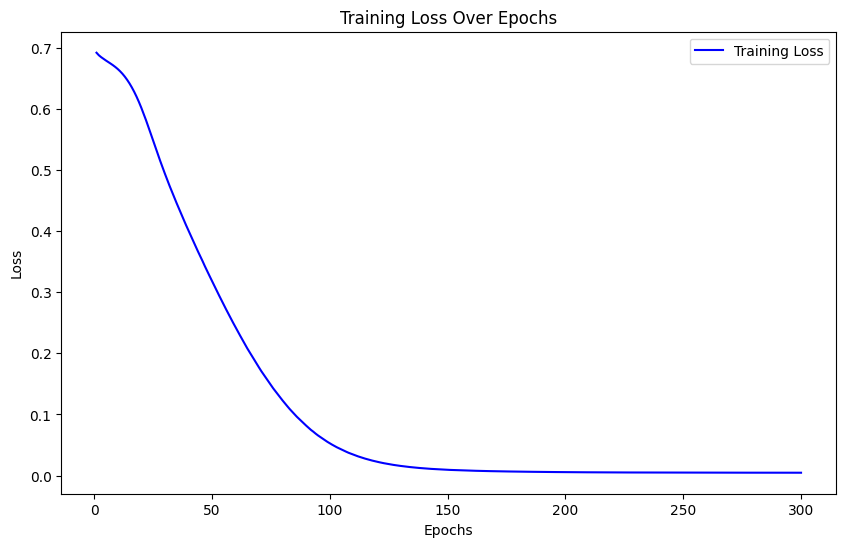

In [17]:
# Loss Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

## Testing

In [18]:
# TESTING
model.eval() 

all_labels = []
all_predictions = []
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:                            # Iterate over each batch (i.e. one patient)
        patient_features = data.x                       # Get features (shape: [num_nodes, in_channels])
        patient_edges = data.edge_index                 # Get edges (shape: [2, num_edges])
        patient_label = data.y.float()                  # Get label (shape: [1])

        # Ensure correct format
        patient_features = patient_features.float()    
        patient_edges = patient_edges.to(torch.long)

        # Forward pass
        output = model(patient_features, patient_edges, data.batch)  # Use the batch info to aggregate across nodes

        # Apply sigmoid to the output logits and get the predicted class (0 or 1)
        pred = torch.sigmoid(output.squeeze())
        predicted_class = (pred >= 0.5).float()                     # Threshold at 0.5 to classify as 0 or 1
        
        # Collect the labels and predictions for metrics
        all_labels.append(patient_label.cpu().numpy())
        all_predictions.append(predicted_class.cpu().numpy())

        # Count correct predictions
        correct += (predicted_class == patient_label).sum().item()
        total += patient_label.size(0)  # Increment by the number of samples in this batch

# Accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")

# Calculate Metrics
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
roc_auc = roc_auc_score(all_labels, all_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Test Accuracy: 71.42857142857143%
Precision: 0.6153846153846154
Recall: 0.8888888888888888
F1-Score: 0.7272727272727273


In [19]:
# Optimized testing with metrics and benchmarking
@benchmark_function
def test_model_optimized(model, test_loader):
    """
    Test the model with comprehensive metrics and benchmarking
    """
    model.eval()
    model = model.to(device)
    
    all_labels = []
    all_probas = []
    all_predictions = []
    
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Testing"):
            data = data.to(device)
            patient_features = data.x.float()
            patient_edges = data.edge_index.long()
            patient_label = data.y.float()
            batch = data.batch
            
            # Forward pass
            output = model(patient_features, patient_edges, batch)
            proba = torch.sigmoid(output.squeeze()).cpu().numpy()
            pred = (proba >= 0.5).astype(float)
            
            # Store results
            all_labels.append(patient_label.cpu().numpy())
            all_probas.append(proba)
            all_predictions.append(pred)
    
    # Convert lists to numpy arrays
    all_labels = np.concatenate(all_labels)
    all_probas = np.array(all_probas)
    all_predictions = np.array(all_predictions)
    
    # Calculate metrics
    accuracy = (all_predictions == all_labels).mean() * 100
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    roc_auc = roc_auc_score(all_labels, all_probas)
    
    # Print results
    print("\nTest Results:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'predictions': all_predictions,
        'probabilities': all_probas,
        'true_labels': all_labels
    }

## Experiments
Test classification with clinical and image embeddings only

In [20]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=128, dropout=0.5):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)             # Binary classification
        return x

In [21]:
# Experiment: Train Clinical-only and Image-only Models
for modality, feature_set in [('Clinical', train_clinical_embeddings), ('Image', train_image_features)]:
    print(f"\nTraining {modality}-Only Model")
    
    train_labels = train_labels.clone().detach().float().view(-1, 1)
    test_labels = test_labels.clone().detach().float().view(-1, 1)
    train_features = torch.tensor(feature_set.reshape(len(feature_set), -1))
    test_features = torch.tensor((test_clinical_embeddings if modality == 'Clinical' else test_image_features).reshape(len(test_labels), -1))

    print("Train Features: ", train_features.shape)
    print("Test Features: ", test_features.shape)
    print("Train Labels: ", train_labels.shape)
    print("Test Labels: ", test_labels.shape)
    
    train_dataset = TensorDataset(train_features, train_labels)
    test_dataset = TensorDataset(test_features, test_labels)
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    test_model = MLP(input_dim=train_features.shape[1])
    test_optimizer = torch.optim.Adam(test_model.parameters(), lr=learning_rate, weight_decay=w_decay)
    
    epochs = 300
    for epoch in range(epochs):
        test_model.train()
        total_loss = 0
        for features, labels in train_loader:
            test_optimizer.zero_grad()
            output = test_model(features.float())

            loss = torch.nn.BCEWithLogitsLoss()(output.view(-1), labels.view(-1))
            loss.backward()
            test_optimizer.step()
            total_loss += loss.item()
            
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss/len(train_loader)}")
    
    test_model.eval()
    all_labels, all_predictions = [], []
    correct = 0
    total = 0

    with torch.no_grad():
        for features, labels in test_loader:
            output = test_model(features.float())

            pred = torch.sigmoid(output.squeeze()) >= 0.5
            
            all_labels.append(labels.cpu().numpy().flatten())
            all_predictions.append(pred.cpu().numpy().flatten())

            # Count correct predictions
            correct += (pred == labels).sum().item()
            total += labels.size(0)  # Increment by the number of samples in this batch
    
    print(f"{modality}-Only Model")

    # Accuracy
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy}%")

    # Calculate Metrics
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    roc_auc = roc_auc_score(all_labels, all_predictions)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")


Training Clinical-Only Model
Train Features:  torch.Size([84, 4864])
Test Features:  torch.Size([21, 4864])
Train Labels:  torch.Size([84, 1])
Test Labels:  torch.Size([21, 1])


/opt/anaconda3/envs/pascal/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/300, Loss: 0.8802260821241708
Epoch 2/300, Loss: 0.7158462093655198
Epoch 3/300, Loss: 0.6561866663839846
Epoch 4/300, Loss: 0.671134847016739
Epoch 5/300, Loss: 0.61417486151636
Epoch 6/300, Loss: 0.5526924502268057
Epoch 7/300, Loss: 0.5295529374963648
Epoch 8/300, Loss: 0.5019920853325553
Epoch 9/300, Loss: 0.4681862158551147
Epoch 10/300, Loss: 0.5360424005179777
Epoch 11/300, Loss: 0.4829019083283908
Epoch 12/300, Loss: 0.41138505720283275
Epoch 13/300, Loss: 0.4360533303124179
Epoch 14/300, Loss: 0.4146284644340908
Epoch 15/300, Loss: 0.4266284666061568
Epoch 16/300, Loss: 0.3389327160421766
Epoch 17/300, Loss: 0.389443481229418
Epoch 18/300, Loss: 0.37014546584957014
Epoch 19/300, Loss: 0.28989216323350864
Epoch 20/300, Loss: 0.3418952292792732
Epoch 21/300, Loss: 0.3274699876400562
Epoch 22/300, Loss: 0.3073837414936168
Epoch 23/300, Loss: 0.34645308139288644
Epoch 24/300, Loss: 0.3119964970213741
Epoch 25/300, Loss: 0.2880344306574137
Epoch 26/300, Loss: 0.268050294125

/var/folders/vn/9n4mdvbj54lbr8ffl0577zgw0000gn/T/ipykernel_70190/4210919272.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(feature_set.reshape(len(feature_set), -1))
/var/folders/vn/9n4mdvbj54lbr8ffl0577zgw0000gn/T/ipykernel_70190/4210919272.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_features = torch.tensor((test_clinical_embeddings if modality == 'Clinical' else test_image_features).reshape(len(test_labels), -1))
/opt/anaconda3/envs/pascal/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/300, Loss: 0.6941930921304793
Epoch 2/300, Loss: 0.6930999056923957
Epoch 3/300, Loss: 0.6967348427999587
Epoch 4/300, Loss: 0.6744392790964672
Epoch 5/300, Loss: 0.6920562560359637
Epoch 6/300, Loss: 0.6849753136436144
Epoch 7/300, Loss: 0.6810790133618173
Epoch 8/300, Loss: 0.6779138059133575
Epoch 9/300, Loss: 0.6814671758384931
Epoch 10/300, Loss: 0.6997014131574404
Epoch 11/300, Loss: 0.6915550437711534
Epoch 12/300, Loss: 0.6813615613750049
Epoch 13/300, Loss: 0.6728436315343493
Epoch 14/300, Loss: 0.6789491570421627
Epoch 15/300, Loss: 0.6749929317406246
Epoch 16/300, Loss: 0.690930921406973
Epoch 17/300, Loss: 0.6822790968276206
Epoch 18/300, Loss: 0.6796494612381572
Epoch 19/300, Loss: 0.6834891002093043
Epoch 20/300, Loss: 0.6739480144211224
Epoch 21/300, Loss: 0.683431058767296
Epoch 22/300, Loss: 0.6826155373737925
Epoch 23/300, Loss: 0.6712520739861897
Epoch 24/300, Loss: 0.6641010705913816
Epoch 25/300, Loss: 0.6768714863629568
Epoch 26/300, Loss: 0.65913867169902